### 1. CV 모델 불러와 실행하기

1. DETR with RESNET-50-backbone
- https://huggingface.co/facebook/detr-resnet-50
- coco 2017 datasets used to pre-train the model

2. YOLOSv5 - v7
- https://huggingface.co/fcakyon/yolov5s-v7.0
- coco datasets (https://huggingface.co/datasets/detection-datasets/coco) used to pre-train the model

In [70]:
%matplotlib inline
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

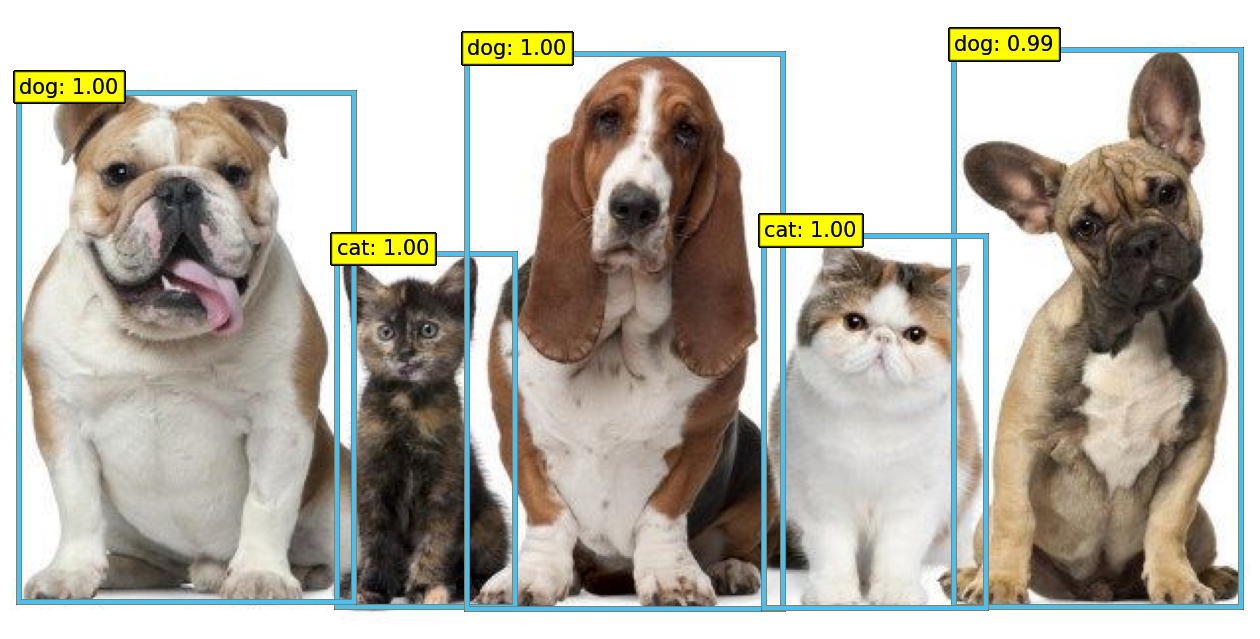

In [72]:
#1. DETR with RESNET-50-backbone

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests
import matplotlib.pyplot as plt

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

image = Image.open('dogcats.jpeg')
#image = Image.open('bustaxi.jpg')
#image = Image.open('personanimal.jpg')

# 모델 불러와서 처리하기
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image,return_tensors="pt")
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

#결과 시각화 (박스 그리고 저장하기)
plt.figure(figsize=(16,10))
plt.imshow(image)
ax = plt.gca()
colors = COLORS * 100

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    for c in (colors):
      xmin, ymin, xmax, ymax = box

      ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                  fill=False, color=c, linewidth=3))
      text = f'{model.config.id2label[label.item()]}: {score.item():0.2f}'
      ax.text(xmin, ymin, text, fontsize=15,
              bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.savefig('final')


In [ ]:
! pip install -U yolov5

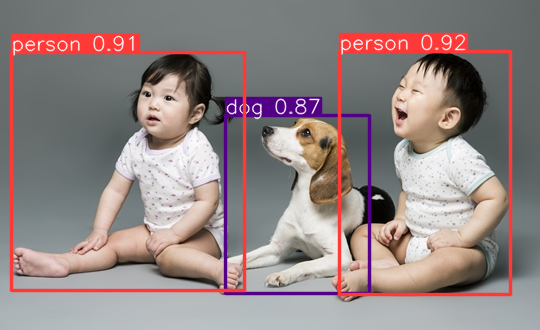

Saved 1 image to runs/detect/exp3


In [67]:
import yolov5

# load model
model = yolov5.load('fcakyon/yolov5s-v7.0')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
#img = 'dogcats.jpeg'
#img = 'bustaxi.jpg'
img = 'personanimal.jpg'

# perform inference
results = model(img)

# inference with larger input size
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
results.save('result1')

#### 1-2. DETR vs YOLOv5

- 전반적으로 DETR에 비해 YOLOv5 기반의 모델 예측 성능이 떨어지는 편. 물체 감지 결과는 동일하나, 예측 확률의 측면에서 DETR이 YOLOv5보다 뛰어남

- 카테고리 1 (동물들) : 두 모델 모두 5개의 개체를 감지하는 것은 성공했으나, YOLOv5는 강아지 사이의 고양이를 강아지로 잘못 분류함.

- 카테고리 2 (차 & 버스) : 두 모델 모두 전면에 드러난 버스, 택시, 운전기사를 감지했으나 DETR은 YOLOv5에 비해 뒷쪽에 겹쳐진 채로 드러난 개체를 잘 감지하지 못함. (결과물 pdf의 2쪽 참고) 차량과 관련된 개체 위주로 감지한 YOLOv5에 비해 DETR은 교통 신호등도 감지함.

- 카테고리 3 (사람 & 동물) : 두 모델 모두 개체 감지는 성공했으나, 예측 확률의 측면에서 DETR이 YOLOv5보다 뛰어남

### 2. NLP 모델 FINE-TUNING

#### 1. 데이터셋 불러오기

- 네이버 영화 리뷰 감성 분석 : https://huggingface.co/datasets/nsmc
- train 150,000개, test 50,000개
- 데이터 구성:
  - id : 리뷰 id
  - document : 리뷰 텍스트
  - label : 부정(0), 긍정(1)

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import torch

device = torch.device('cuda')
dataset = load_dataset('nsmc')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset = dataset.rename_column(
    original_column_name = 'label', new_column_name = 'labels'
)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'labels'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'labels'],
        num_rows: 50000
    })
})

#### 2. Huggingface에서 모델 불러온 뒤 fine-tuning 하기

- 사용한 모델 : https://huggingface.co/bert-base-multilingual-cased


- 토크나이저와 모델 가중치 불러오기

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- document 텍스트 토크나이징

In [ ]:
def tokenize_function(data):
    return tokenizer(data["document"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
tokenized_data = tokenized_datasets.remove_columns(['id']) #학습 및 결과 도출에 불필요한 id 삭제

In [ ]:
tokenized_data.set_format("torch")

- 학습 데이터와 검증 데이터 분류하기

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(6000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))
#train_dataset = tokenized_datasets["train"]
#eval_dataset = tokenized_datasets["test"]

- 평가 메트릭 지정

In [ ]:
!pip install evaluate

In [ ]:
! pip install accelerate -U
! pip install transformers -U

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

- transformers에서 Trainer 불러와 학습하기

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="steps",logging_steps=500, num_train_epochs = 5,load_best_model_at_end=True)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.706400,0.721794,0.483500
1000,0.705000,0.696906,0.483500
1500,0.689000,0.693414,0.575500
2000,0.648700,0.627592,0.666500
2500,0.617900,0.625918,0.676000


Step,Training Loss,Validation Loss,Accuracy
500,0.706400,0.721794,0.483500
1000,0.705000,0.696906,0.483500
1500,0.689000,0.693414,0.575500
2000,0.648700,0.627592,0.666500
2500,0.617900,0.625918,0.676000
3000,0.643400,0.654649,0.598500
3500,0.637100,0.631741,0.685500


TrainOutput(global_step=3750, training_loss=0.6601331746419271, metrics={'train_runtime': 3319.2813, 'train_samples_per_second': 9.038, 'train_steps_per_second': 1.13, 'total_flos': 7893331660800000.0, 'train_loss': 0.6601331746419271, 'epoch': 5.0})

- 최종 모델 저장

In [ ]:
trainer.save_model('finalmodel')

#### 3. Fine-tuning한 모델로 주어진 텍스트 감성분석하기

In [55]:
model = BertForSequenceClassification.from_pretrained('finalmodel')

In [ ]:
model

In [57]:
def classify_emotion(text):
    # 텍스트 토큰화 및 패딩
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    # 예측 수행
    with torch.no_grad():
        prediction = model(**tokens)

		# 예측 결과를 바탕으로 감정 출력
    prediction = F.softmax(prediction.logits, dim=1)
    output = prediction.argmax(dim=1).item()
    labels = ["부정", "긍정"]
    print(f'[{labels[output]}]\n')

In [58]:
def predict_sentence():
    input_sentence = input('문장을 입력해 주세요: ')
    classify_emotion(input_sentence)

predict_sentence()

문장을 입력해 주세요: 실제 역사를 거의 그대로 다루다보니 보면서 화가 나긴 하지만 영화적으로 흥미롭게 구성을 잘 해서 몰입도가 높아요. 몇 번을 봐도 볼 때마다 새롭게 보이는 면이 있구요. 의미와 재미를 다 잡은 작품이에요!
[긍정]



- Fine-tuning 되지 않은 원본 모델로 감성 분석하기

In [51]:
from transformers import BertTokenizer, BertModel,BertForSequenceClassification
import torch.nn.functional as F


tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")


text = '''실제 역사를 거의 그대로 다루다보니 보면서 화가 나긴 하지만 영화적으로 흥미롭게 구성을 잘
해서 몰입도가 높아요. 몇 번을 봐도 볼 때마다 새롭게 보이는 면이 있구요. 의미와 재미를 다 잡은
작품이에요!'''


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
predict_sentence()

문장을 입력해 주세요: 실제 역사를 거의 그대로 다루다보니 보면서 화가 나긴 하지만 영화적으로 흥미롭게 구성을 잘 해서 몰입도가 높아요. 몇 번을 봐도 볼 때마다 새롭게 보이는 면이 있구요. 의미와 재미를 다 잡은 작품이에요!
[부정]



- 영어 데이터로 학습된 원본 모델을 한국어 데이터셋을 활용해 fine-tuning한 결과, 주어진 문장을 옳게 분류함.